In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go

### Reading file

In [186]:
df = pd.read_csv("data.csv")
df.timestamp = pd.to_datetime(df.timestamp, unit='s')
df.date = pd.to_datetime(df.date)

In [190]:
df.sample(5)

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
13164,2023-04-25 20:47:42,user_7348,0,NaN,Ярославь,17.0,0,2023-04-25
11904,2023-04-23 21:52:59,user_5261,0,NaN,Ярославь,18.0,0,2023-04-24
31882,2023-05-18 15:41:23,user_2875,10,B,Москва,6.0,1,2023-05-18
27249,2023-05-10 17:57:03,user_8396,0,A,Рязань,12.0,0,2023-05-10
13004,2023-04-24 21:32:22,user_1726,0,NaN,Москва,10.0,0,2023-04-25


In [192]:
pre_group = df[df["group"].isna()]
group_a = df[df["group"] == "A"]
group_b = df[df["group"] == "B"]

### Data description

In [326]:
print("Pre-period")
print(f"The test period ranges from {pre_group['date'].min().strftime('%Y-%m-%d')} to {pre_group['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of unique users: {pre_group['id_user'].nunique()}")
print(f"Number of events: {pre_group['id_user'].count()}")

print("\nGroup A")
print(f"The test period ranges from {group_a['date'].min().strftime('%Y-%m-%d')} to {group_a['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of unique users: {group_a['id_user'].nunique()}")
print(f"Number of events: {group_a['id_user'].count()}")

print("\nGroup B")
print(f"The test period ranges from {group_b['date'].min().strftime('%Y-%m-%d')} to {group_b['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of unique users: {group_b['id_user'].nunique()}")
print(f"Number of events: {group_b['id_user'].count()}")

Pre-period
The test period ranges from 2023-04-01 to 2023-04-30
Number of unique users: 10000
Number of events: 25759

Group A
The test period ranges from 2023-05-01 to 2023-05-31
Number of unique users: 6000
Number of events: 15389

Group B
The test period ranges from 2023-05-01 to 2023-05-31
Number of unique users: 6000
Number of events: 15257


### Outlier's analysis

In [213]:
threshold = 0.01

#### Pre-experiment

In [216]:
lower_bound = pre_group.sum_payment.quantile(threshold)
upper_bound = pre_group.sum_payment.quantile(1 - threshold)
outliers = pre_group[
    (pre_group.sum_payment < lower_bound) | (pre_group.sum_payment > upper_bound)
]

Replace outliers with lower and upper bound values

In [223]:
pre_group.loc[
    pre_group.index.isin(outliers.index), "sum_payment"
] = pre_group.loc[pre_group.index.isin(outliers.index), "sum_payment"].apply(lambda x: min(x, upper_bound))

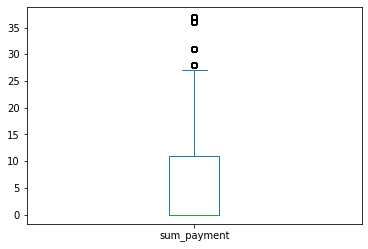

In [228]:
_, bp = pre_group.sum_payment.plot.box(return_type='both')

#### Duration for experiment

In [229]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha / 2) + sps.norm.ppf(1 - beta)
    n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (delta_effect ** 2)
    return n

In [251]:
def metric(df):
    df_first = df.groupby("id_user", as_index=False)["timestamp"].min()
    df_first["next_week"] = df_first["timestamp"] + pd.Timedelta(days=7)
    
    df_tmp = (
        df
        .merge(df_first.drop(["timestamp"], axis=1),
               on=["id_user"]
              )
        .query("timestamp < next_week")
        .groupby("id_user", as_index=False)
        .agg({"sum_payment": sum})
        .sort_values("sum_payment", ascending=False)
    )
    
    return df_tmp.sum_payment.to_numpy()    

In [270]:
est_size = int(
    duration(
        1,
        np.mean(metric(pre_group)) * 0.1,
        np.std(metric(pre_group), ddof=1),
        np.std(metric(pre_group), ddof=1)
    ) * 0.5
) 
total_size = group_a["id_user"].nunique()

In [275]:
print(f"With our estimation we need a sample-size: {est_size}. We actually have {total_size} for each sample.")
print("It's possible to filter some data in group A and B dataframes to decrease size to calculated amount. But I decided to leave it that much.")

With our estimation we need a sample-size: 3610. We actually have 6000 for each sample.
It's possible to filter some data in group A and B dataframes to decrease size to calculated amount. But I decided to leave it that much.


### Getting rid of outliers in experimental groups

#### Group A

In [279]:
lower_bound = group_a.sum_payment.quantile(threshold)
upper_bound = group_a.sum_payment.quantile(1 - threshold)
outliers = group_a[
    (group_a.sum_payment < lower_bound) | (group_a.sum_payment > upper_bound)
]

group_a.loc[
    group_a.index.isin(outliers.index), "sum_payment"
] = group_a.loc[group_a.index.isin(outliers.index), "sum_payment"].apply(lambda x: min(x, upper_bound))

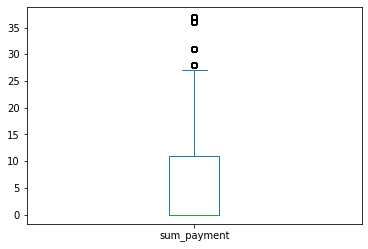

In [280]:
_, bp = pre_group.sum_payment.plot.box(return_type='both')

#### Group B

In [282]:
lower_bound = group_b.sum_payment.quantile(threshold)
upper_bound = group_b.sum_payment.quantile(1 - threshold)
outliers = group_b[
    (group_b.sum_payment < lower_bound) | (group_b.sum_payment > upper_bound)
]

group_b.loc[
    group_b.index.isin(outliers.index), "sum_payment"
] = group_b.loc[group_b.index.isin(outliers.index), "sum_payment"].apply(lambda x: min(x, upper_bound))

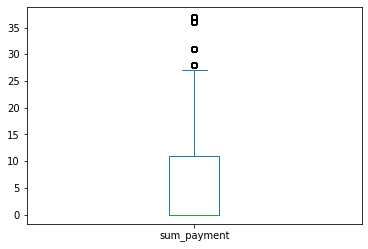

In [283]:
_, bp = pre_group.sum_payment.plot.box(return_type='both')

### A/A test checking

In [284]:
def qq_plot(x_1, x_2):
    p_values = []
    n_exp = 10_000
    size = 100
    for _ in range(n_exp):
        x_a = np.random.choice(x_1, size=size)
        x_b = np.random.choice(x_2, size=size)
        p_values.append(sps.ttest_ind(x_a, x_b, equal_var=False).pvalue)

    p_values = np.array(p_values)    
    probs = []
    x = [0.01 * i for i in range(101)]
    
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(np.mean(p_values < alpha_step))
        
    fig = go.Figure([go.Scatter(x=x, y=probs, name="p_value", mode="markers"),
                    go.Scatter(x=x, y=x, mode="lines", name="uniform")])
    fig.update_layout(height=400, width=600)
    fig.show()

In [285]:
qq_plot(metric(pre_group), metric(pre_group))

### A/B test analysis

In [289]:
def dynamic_metric(df, eop):
    df_first = df.groupby("id_user", as_index=False)["timestamp"].min()
    df_first["next_week"] = df_first["timestamp"] + pd.Timedelta(days=7)
    
    df_tmp = (
        df
        .merge(df_first.drop(["timestamp"], axis=1),
               on=["id_user"]
              )
        .query(f"timestamp < next_week & next_week <= @eop")
        .groupby("id_user", as_index=False)
        .agg({"sum_payment": sum})
        .sort_values("sum_payment", ascending=False)
    )
    
    return df_tmp.sum_payment.to_numpy()  

In [313]:
res = []
for t_date in pd.date_range('2023-05-09', '2023-06-01'):
    x_A = dynamic_metric(group_a, t_date)
    x_B = dynamic_metric(group_b, t_date)   
    p_value = sps.ttest_ind(x_A, x_B).pvalue
    res.append((t_date, np.mean(x_A), np.mean(x_B), np.mean(x_B) - np.mean(x_A), p_value))
    
df_res = pd.DataFrame(res, columns=["date", "mean_A", "mean_B", "effect", "p_value"]).set_index("date")
df_res.index.name = None

In [314]:
df_res.tail(1)

,mean_A,mean_B,effect,p_value
2023-06-01,11.320149,12.722878,1.402729,0.000801


In [322]:
fig = go.Figure([go.Scatter(x=pd.date_range('2023-05-09', '2023-05-31'), y=df_res.p_value, name="p_value"),
          go.Scatter(x=pd.date_range('2023-05-09', '2023-05-31'), y=[0.05] * df_res.shape[0], name="alpha")])
fig.update_layout(title="P_value dynamic throught testing period")

Making one more qq-plot, just for research

In [321]:
qq_plot(df_res.mean_A, df_res.mean_B)

### Conclusion

We did some great work! Our changes lead us to big success and we should reject our null hypothesis, because there is a difference!